# Inferential statistics II - Bootstrapping

## Introduction

In the previous exercises you performed frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold in your case, and what you want to do has a known theoretical distribution, for example the mean of a sampling distribution that we looked at.

In these exercises we are once again going to load in the medical charge data but this time we are going to make inferences about the population using bootstrapping, that is simulating repeated re-runs of an experiment. If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

Whilst these exercises do not strictly depend on these concepts, before working through them, you should have completed the preceding assignment and have a good understanding of such frequentist concepts as
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete these exercises, you should have covered the material on how to calculate bootstrap replicates of summary statistics. Having an appreciation of what confidence intervals and p-values are will be helpful.

In [161]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import t


## Medical charge data set

In [162]:
med_charges = pd.read_csv('data/insurance2.csv')

In [163]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you would like to verify your calculations and check you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A: The lower bound was calculated with np.percentile [5.0, 95.0] which is like one-sided. Note that this is interpreting one-sided as "1 - alpha", compared to two_sided where the parameter would be "1 - alpha/2" on each side. The result is close to the expected answer provided. Can we use the cv, std, stderr, margin, mean to compare to t CI?__

In [220]:
np.random.seed(47)
N_rep = 10000
boot_sample = np.empty(N_rep)

for i in range(N_rep):
    boot_sample[i] = np.mean(np.random.choice(med_charges.charges, size=len(med_charges.charges)))


med_percentile = np.percentile(boot_sample, [5.0, 95.0])
print("The 95% bootstrap sample one-sided? (1-p) is " +str(med_percentile))    
print("The mean of boot_sample is " + str(np.mean(boot_sample)))
print("Median of boot_sample is " + str(np.median(boot_sample)))
print("Std of boot_sample is " + str(np.std(boot_sample)))

df12k = len(med_charges.charges) - 1
charge_mean = np.mean(med_charges.charges)
charge_median = np.median(med_charges.charges)
charge_std = np.std(med_charges.charges, ddof=1)
print("Mean is " + str(charge_mean))
print("Median is " + str(charge_median))
print("Std is " + str(charge_std))


cv_12k = t.ppf(.95, df12k)
print("Critical Value t-one sided is " + str(cv_12k))
stderr_12k = charge_std / np.sqrt(df12k)
print("Standard error for sample is " + str(stderr_12k))
margin_12k =  cv_12k * stderr_12k 
print("Margin of Error is " + str(margin_12k))
print("Range is " + str(charge_mean - margin_12k) + " to " + str(charge_mean + margin_12k))
interval_12k = t.interval(.90, df12k, loc=charge_mean, scale=stderr_12k)
print("The t-interval 95% alpha one-sided (1-p) is " + str(interval_12k))


med_percentile2 = np.percentile(boot_sample, [2.5, 97.5])
print("The 95% bootstrap sample two-sided?  is " +str(med_percentile2))  

The 95% bootstrap sample one-sided? (1-p) is [12724.4679217  13813.35213297]
The mean of boot_sample is 13268.292567069491
Median of boot_sample is 13270.119707106129
Std of boot_sample is 331.9939687156728
Mean is 13270.422265141257
Median is 9382.033
Std is 12110.011236693994
Critical Value t-one sided is 1.6459941145571317
Standard error for sample is 331.1912409920272
Margin of Error is 545.1388334657494
Range is 12725.283431675507 to 13815.561098607006
The t-interval 95% alpha one-sided (1-p) is (12725.283431675507, 13815.561098607006)
The 95% bootstrap sample two-sided?  is [12624.86211913 13918.00929997]


If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember in the previous exercise set, we saw there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A: The difference between the standard deviations of the insured/uninsured samples is not very meaningful. See the insured, uninsured, and diff of the std statistic for the samples. Whether the std is the same between the insured and uninsured samples is the null hypothesis, and the alternative is that the std of hte samples is different. Clearly, the std stats are different, and the graph shows the distribution of insured, uninsured, and diff. However, whether the std is the same or different does not necessarily tell us whether the sample means are different, except to the extent that it defines the range of values for a given condifence level. Perhaps the null hypothesis should be whether the sample means for the insured vs uninsured samples is the same, with alternative that they are different.__

In [165]:
uninsured = med_charges.loc[med_charges.insuranceclaim == 0]
insured = med_charges.loc[med_charges.insuranceclaim == 1]

The 95% bootstrap sample insured two-sided is [13323.62673794 14710.21926089]
The mean of boot_sample insured is 14023.06524624154
Std of boot_sample insured is 353.30343647241284

The 95% bootstrap sample uninsured two-sided is [5847.92681965 7013.83494024]
The mean of boot_sample ininsured is 6426.1728423761315
Std of boot_sample uninsured is 298.59764094593305

The 95% bootstrap sample std diff two-sided is [6684.31447766 8500.74902263]
The mean of boot_sample ininsured is 7596.89240386541
Std of boot_sample uninsured is 463.5080279419994


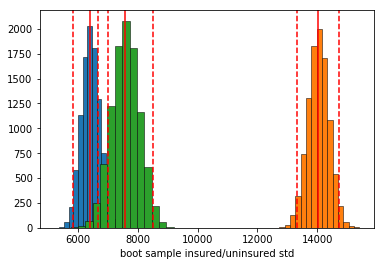

In [166]:
np.random.seed(47)
N_rep = 10000
boot_sample_insured_s = np.empty(N_rep)

for i in range(N_rep):
    boot_sample_insured_s[i] = np.std(np.random.choice(insured.charges, size=len(insured.charges)))


boot_sample_insured_percentile_s = np.percentile(boot_sample_insured_s, [2.5, 97.5])
print("The 95% bootstrap sample insured two-sided is " +str(boot_sample_insured_percentile_s))    
print("The mean of boot_sample insured is " + str(np.mean(boot_sample_insured_s)))
print("Std of boot_sample insured is " + str(np.std(boot_sample_insured_s)))

boot_sample_uninsured_s = np.empty(N_rep)
for i in range(N_rep):
    boot_sample_uninsured_s[i] = np.std(np.random.choice(uninsured.charges, size=len(uninsured.charges)))

print('')
boot_sample_uninsured_percentile_s = np.percentile(boot_sample_uninsured_s, [2.5, 97.5])
print("The 95% bootstrap sample uninsured two-sided is " +str(boot_sample_uninsured_percentile_s))    
print("The mean of boot_sample ininsured is " + str(np.mean(boot_sample_uninsured_s)))
print("Std of boot_sample uninsured is " + str(np.std(boot_sample_uninsured_s)))

boot_sample_std_diff_s = np.empty(N_rep)
for i in range(N_rep):
    boot_sample_std_diff_s[i] = boot_sample_insured_s[i] - boot_sample_uninsured_s[i]

print('')
boot_sample_std_diff_percentile_s = np.percentile(boot_sample_std_diff_s, [2.5, 97.5])
print("The 95% bootstrap sample std diff two-sided is " +str(boot_sample_std_diff_percentile_s))    
print("The mean of boot_sample ininsured is " + str(np.mean(boot_sample_std_diff_s)))
print("Std of boot_sample uninsured is " + str(np.std(boot_sample_std_diff_s)))


_ = plt.hist(boot_sample_uninsured_s,  edgecolor = 'black', linewidth = 0.5, bins = 15)
_ = plt.xlabel('boot sample insured/uninsured std')
_ = plt.axvline(np.mean(boot_sample_uninsured_s), color='r')
_ = plt.axvline(boot_sample_uninsured_percentile_s[0], color='r', linestyle='--')
_ = plt.axvline(boot_sample_uninsured_percentile_s[1], color='r', linestyle='--')

_ = plt.hist(boot_sample_insured_s,  edgecolor = 'black', linewidth = 0.5, bins = 15)
_ = plt.axvline(np.mean(boot_sample_insured_s), color='r')
_ = plt.axvline(boot_sample_insured_percentile_s[0], color='r', linestyle='--')
_ = plt.axvline(boot_sample_insured_percentile_s[1], color='r', linestyle='--')

_ = plt.hist(boot_sample_std_diff_s,  edgecolor = 'black', linewidth = 0.5, bins = 15)
_ = plt.axvline(np.mean(boot_sample_std_diff_s), color='r')
_ = plt.axvline(boot_sample_std_diff_percentile_s[0], color='r', linestyle='--')
_ = plt.axvline(boot_sample_std_diff_percentile_s[1], color='r', linestyle='--')
#_ = plt.legend(['uninsured std', 'std diff', 'insured std'])

__The difference of standard deviations on the sample means, or the stderr and t-statistic are calculated manually below per execise 1b. The ttest_ind() function result for 95% confidence matches the t-statistic. The p-value is virtually zero, and is the same when using the parameter dir unequal variances of the samples. The results is that the null should be rejected, and the difference in means of about 7603 should be accepted with a high degree of confidence. The 95% confidence t-interval range on the sample mean difference is 7582 and 7618, so zero is extremely far from the range.__

In [150]:
n1 = len(boot_sample_uninsured)
n0 = len(boot_sample_insured)
print("The number of charges uninsured is " + str(n1))
print("The number of charges insured is " + str(n0))

s1 = np.std(boot_sample_uninsured, ddof=1)
s0 = np.std(boot_sample_insured, ddof=1)
print('')
print("The std charge uninsured is " + str(s1))
print("The std charge insured is " + str(s0))

x1 = np.mean(boot_sample_uninsured)
x0 = np.mean(boot_sample_insured)
print('')
print("The mean charge uninsured is " + str(x1))
print("The mean charge insured " + str(x0))

sp = np.sqrt(((n0 -1) * s0 ** 2 + (n1 -1) * s1 ** 2) / (n0 + n1 -2))
print('')
print("The calculated stdev_diff is " + str(sp))

t_stat = (x0 - x1) / (sp * np.sqrt(((1/n0) + (1/n1))))
print('')
print("The calculated t-stat is " + str(t_stat))

boot_sample_mean_diff = np.empty(N_rep)
for i in range(N_rep):
    boot_sample_mean_diff[i] = np.mean(np.random.choice(insured.charges, size=len(insured.charges))) - np.mean(np.random.choice(uninsured.charges, size=len(uninsured.charges)))
print('')
print("The boot sample mean diff is " + str(np.mean(boot_sample_mean_diff)))
print("The std of boot sample mean diff is " + str(np.std(boot_sample_mean_diff)))

from scipy.stats import ttest_ind
print(ttest_ind(boot_sample_insured, boot_sample_uninsured, equal_var=True))
print(ttest_ind(boot_sample_insured, boot_sample_uninsured, equal_var=False))

ci95_mean_interval = t.interval(.90, N_rep, loc=np.mean(boot_sample_mean_diff), scale=np.std(boot_sample_mean_diff))
print('')
print("The t-interval 95% alpha two-side (1-p)/2 is " + str(ci95_mean_interval))


The number of charges uninsured is 10000
The number of charges insured is 10000

The std charge uninsured is 179291.31416066297
The std charge insured is 353.3211029692348

The mean charge uninsured is 124815.16922368805
The mean charge insured 14023.06524624154

The calculated stdev_diff is 126778.3502204918

The calculated t-stat is -61.79434255779952

The boot sample mean diff is 7598.718157772428
The std of boot sample mean diff is 572.4147953475501
Ttest_indResult(statistic=-61.79434255779952, pvalue=0.0)
Ttest_indResult(statistic=-61.79434255779952, pvalue=0.0)

The t-interval 95% alpha two-side (1-p)/2 is (7580.779384302862, 7616.656931241993)


## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type II error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this but using the bootstrap.

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A: The hypothesis and result was stated above, confirming the statistical difference in sample means. See the graph of the distribution of observed sample means for the insured/uninsured groups as well as the difference between them. The intuition is similar to above when looking at the std statistic of each sampling group, but the test is more meaningful.
See p_value calculated as proportion of sample diffs vs mean of sample diffs. The t.interval() from exercise 1b confidence interval is shown along with the equivalent function for norm.interval(). Note the values are the same, and the t parameter includes the sample size of 10,000. The p-value is virtually zero using z or t.__

The 95% bootstrap sample insured mean two-sided is [15462.58983159 17405.7858685 ]
The mean of boot_sample mean insured is 16426.385045623112
Std of boot_sample mean insured is 496.174533707796

The 95% bootstrap sample uninsured mean two-sided is [8295.64147363 9366.19204212]
The mean of boot_sample mean uninsured is 8820.03742661969
Std of boot_sample mean uninsured is 273.4820454191606

The 95% bootstrap sample mean diff two-sided is [6493.67971396 8703.98117948]
The mean of boot_sample means diff is 7606.34761900342
Std of boot_sample means diff is 566.2893905795102


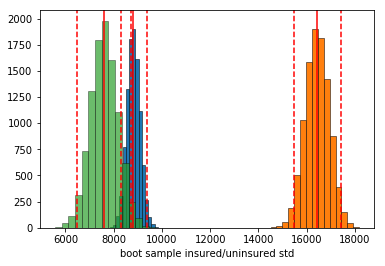

In [218]:
np.random.seed(47)
N_rep = 10000
boot_sample_insured_m = np.empty(N_rep)

for i in range(N_rep):
    boot_sample_insured_m[i] = np.mean(np.random.choice(insured.charges, size=len(insured.charges)))


boot_sample_insured_percentile_m = np.percentile(boot_sample_insured_m, [2.5, 97.5])
print("The 95% bootstrap sample insured mean two-sided is " +str(boot_sample_insured_percentile_m))    
print("The mean of boot_sample mean insured is " + str(np.mean(boot_sample_insured_m)))
print("Std of boot_sample mean insured is " + str(np.std(boot_sample_insured_m)))

boot_sample_uninsured_m = np.empty(N_rep)
for i in range(N_rep):
    boot_sample_uninsured_m[i] = np.mean(np.random.choice(uninsured.charges, size=len(uninsured.charges)))

print('')
boot_sample_uninsured_percentile_m = np.percentile(boot_sample_uninsured_m, [2.5, 97.5])
print("The 95% bootstrap sample uninsured mean two-sided is " +str(boot_sample_uninsured_percentile_m))    
print("The mean of boot_sample mean uninsured is " + str(np.mean(boot_sample_uninsured_m)))
print("Std of boot_sample mean uninsured is " + str(np.std(boot_sample_uninsured_m)))

boot_sample_std_diff_m = np.empty(N_rep)
for i in range(N_rep):
    boot_sample_std_diff_m[i] = boot_sample_insured_m[i] - boot_sample_uninsured_m[i]

print('')
boot_sample_std_diff_percentile_m = np.percentile(boot_sample_std_diff_m, [2.5, 97.5])
print("The 95% bootstrap sample mean diff two-sided is " +str(boot_sample_std_diff_percentile_m))    
print("The mean of boot_sample means diff is " + str(np.mean(boot_sample_std_diff_m)))
print("Std of boot_sample means diff is " + str(np.std(boot_sample_std_diff_m)))


_ = plt.hist(boot_sample_uninsured_m,  edgecolor = 'black', linewidth = 0.5, bins = 15)
_ = plt.xlabel('boot sample insured/uninsured std')
_ = plt.axvline(np.mean(boot_sample_uninsured_m), color='r')
_ = plt.axvline(boot_sample_uninsured_percentile_m[0], color='r', linestyle='--')
_ = plt.axvline(boot_sample_uninsured_percentile_m[1], color='r', linestyle='--')

_ = plt.hist(boot_sample_insured_m,  edgecolor = 'black', linewidth = 0.5, bins = 15)
_ = plt.axvline(np.mean(boot_sample_insured_m), color='r')
_ = plt.axvline(boot_sample_insured_percentile_m[0], color='r', linestyle='--')
_ = plt.axvline(boot_sample_insured_percentile_m[1], color='r', linestyle='--')

_ = plt.hist(boot_sample_std_diff_m,  edgecolor = 'black', linewidth = 0.5, bins = 15, alpha=.7)
_ = plt.axvline(np.mean(boot_sample_std_diff_m), color='r')
_ = plt.axvline(boot_sample_std_diff_percentile_m[0], color='r', linestyle='--')
_ = plt.axvline(boot_sample_std_diff_percentile_m[1], color='r', linestyle='--')
#_ = plt.legend(['uninsured std', 'std diff', 'insured s
#plt.show()

In [217]:
#ci95_mean_interval = t.interval(.025, N_rep, loc=np.mean(boot_sample_mean_diff), scale=np.std(boot_sample_mean_diff))
#print('')
#print("The t-interval 95% alpha two-side (1-p)/2 is " + str(ci95_mean_interval))
ci95_mean_interval = t.interval(.90, N_rep, loc=np.mean(boot_sample_mean_diff), scale=np.std(boot_sample_mean_diff))
print('')
print("The t-interval 95% alpha two-side (1-p)/2 is " + str(ci95_mean_interval))

from scipy.stats import norm
ci95_mean_interval_z = norm.interval(.90, loc=np.mean(boot_sample_mean_diff), scale=np.std(boot_sample_mean_diff))
print('')
print("The z-interval 95% alpha two-side (1-p)/2 is " + str(ci95_mean_interval))
print('')
print("The boot sample mean is " + str(np.mean(boot_sample_mean_diff)))
p_value_norm = np.sum(boot_sample_std_diff_m <= np.mean(boot_sample_mean_diff) / len(boot_sample_std_diff))
print("The calculated p_value_norm is " + str(p_value_norm))
p_value_num = np.sum(boot_sample_std_diff_m <= np.mean(boot_sample_mean_diff))
print("The number of sample diffs less than or equal to the mean sample dif is " + str(p_value_num))
p_value_len = len(boot_sample_std_diff_m)
print("The sample size is " + str(p_value_len))
mean_insured = np.mean(insured.charges)
mean_uninsured = np.mean(uninsured.charges)
diff_mean = mean_insured - mean_uninsured
print("The mean_insured is " + str(mean_insured))
print("The mean_uninsured is " + str(mean_uninsured))
print("The diff_mean is " + str(diff_mean))


The t-interval 95% alpha two-side (1-p)/2 is (6657.0923745938335, 8540.343940951021)

The z-interval 95% alpha two-side (1-p)/2 is (6657.0923745938335, 8540.343940951021)

The boot sample mean is 7598.718157772428
The calculated p_value_norm is 0
The number of sample diffs less than or equal to the mean sample dif is 4984
The sample size is 10000
The mean_insured is 16423.928276537663
The mean_uninsured is 8821.421892306294
The diff_mean is 7602.506384231368


__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

__A: The lines selceted for the graph are the confidence interval boundries and the mean__

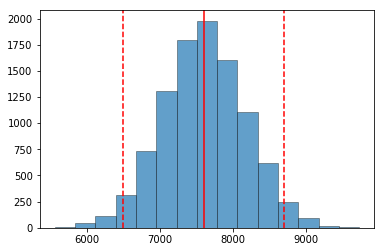

In [136]:
_ = plt.hist(boot_sample_std_diff_m,  edgecolor = 'black', linewidth = 0.5, bins = 15, alpha=.7)
_ = plt.axvline(np.mean(boot_sample_std_diff_m), color='r')
_ = plt.axvline(boot_sample_std_diff_percentile_m[0], color='r', linestyle='--')
_ = plt.axvline(boot_sample_std_diff_percentile_m[1], color='r', linestyle='--')

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A: The p_value is almost zero in both test, and the number of samples is large, so we would expect convergence.__

__Q:__ Remember the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A: It doesn't make much difference with a huge sample and for differences which look large anyway. It's still unclear how to get the p_value for normal(z). I used the sample mean diff for comparison but should the actual difference of the means from the true data sample be used? The numbers are close but does this mean the p_value is more about the validity of geberating sample data rather than validating the actual data?__

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real world consequence of rejecting the null hypothesis?

__A: The same test could be performed, with the null hypothesis being there is no difference in click rate, and the alternative is that it makes a difference. The real world consequence of rejecting would be to recommend implementing the change in production, anticipating a higher click through result in practice.__

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.